# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [8]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = '/Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks'
file_container_obj = FileContainer(ROOT_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Select .bhv2/.h5 behavior file (i.e. 230927_Aragorn_choice.h5)
Behavior file selected: 
  MonkeyLogic Date: 


IndexError: list index out of range

***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [5]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 329
Parsing session data...


  0%|          | 0/329 [00:00<?, ?it/s]

  Complete.
    Correct trials: 216
    Errored trials: 113
    Session Length:  01:35:15
Creating Session Objects...
Lick threshold: 2.53 mV
Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No fractal column found, skipping fractal count...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...


In [6]:
from config.add_fields import add_fields
# save is lick
# lick is photodiode
# photodiode is save
if session_obj.monkey == 'gandalf':
  session_obj.df['cam_save_2'] = session_obj.df['cam_save'].copy()
  session_obj.df['cam_sync_2'] = session_obj.df['cam_sync'].copy()
  session_obj.df['cam_sync'] = session_obj.df['lick'].copy() # correct
  session_obj.df['cam_save'] = session_obj.df['cam_sync_2'].copy()
  session_obj.df['lick'] = session_obj.df['cam_save_2'].copy()
  del session_obj.df['cam_sync_2']
  del session_obj.df['cam_save_2']

  session_obj.df, session_obj = \
  add_fields(session_obj.df, session_obj, behavioral_code_dict)

Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No fractal column found, skipping fractal count...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...


In [7]:
session_obj.df.head()

,date,session_num,subject,trial_num,block,condition,correct,error,error_type,behavioral_code_markers,behavioral_code_times,eye_x,eye_y,eye_pupil,lick,cam_sync,cam_save,photodiode,trial_start,trial_end,trial_datetime_start,trial_datetime_end,Start trial,Frame skipped,Manual reward,End trial,Start,Reward,lick_raster,DEM_raster,trial_bins,trial_in_block,cam_frames
0,231023,0,gandalf,1,1,1,0,1,6,"[9, 10, 18]","[2.702400030102581, 2778.226900030859, 9770.92...","[5.883731561457564, 5.88686447631961, 5.871871...","[0.9890250719814028, 1.0159748381095408, 0.995...","[8938.0, 8932.0, 8939.0, 8939.0, 8918.0, 8918....","[0.006910999223200209, 0.0072398264486985275, ...","[3.309981147165889, 3.322805431050596, 0.00526...","[0.000992109151831927, 0.01282988927112308, -0...","[1.0029284518098052, 1.0249598691046526, 1.023...",0.0000,9775.0000,2023-10-23 10:53:38.719,2023-10-23 10:53:48.494,2,<NA>,<NA>,9770,2778,<NA>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9773,0,"[665, 673, 681, 690, 698, 706, 715, 723, 731, ..."
1,231023,0,gandalf,2,1,1,1,0,0,"[9, 10, 50, 18]","[250.4837000160478, 310.7704000431113, 12859.1...","[77.42892992291698, 77.42892992291698, 77.4289...","[93.16831251019393, 93.16831251019393, 93.1683...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.005266863094622737, 0.006910999223200209, 0...","[3.334643231809826, 3.3182018419314097, -0.003...","[3.309981147165889, 3.319517153104616, 3.32412...","[1.8845140705303702, 1.8861582066766285, 1.787...",9773.8415,23029.8415,2023-10-23 10:53:48.493,2023-10-23 10:54:01.749,250,<NA>,<NA>,13173,310,12859,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13256,1,"[6, 15, 23, 31, 40, 48, 56, 65, 73, 81, 90, 98..."
2,231023,0,gandalf,3,1,1,0,1,6,"[9, 10, 18]","[175.6924000219442, 231.77830001804978, 16280....","[1.7131865775061006, 1.6678821712640124, 1.667...","[-9.211074539236456, -9.246615232463677, -9.24...","[6347.0, 6354.0, 6354.0, 6361.0, 6361.0, 6357....","[5.00015899372057, 4.983388711362921, 4.997528...","[3.3234630866420156, 3.322147775459917, 3.3408...","[3.323134258846213, 3.339575648864042, 3.34911...","[0.617543059554322, 0.6076782454860171, 0.6024...",23029.8410,39392.8410,2023-10-23 10:54:01.749,2023-10-23 10:54:18.112,175,<NA>,<NA>,16280,231,<NA>,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16363,2,"[9, 17, 25, 34, 42, 50, 59, 67, 75, 84, 92, 10..."
3,231023,0,gandalf,4,1,1,1,0,0,"[9, 10, 50, 18]","[171.26039997674525, 231.6389000043273, 12779....","[0.9207086573275246, 0.9002815780365547, 0.900...","[-10.068718995668373, -10.05189467782281, -10....","[5848.0, 5852.0, 5852.0, 5855.0, 5855.0, 5848....","[4.998186019282985, 4.995226557647911, 4.99029...","[-0.0009808542105267382, 0.0003344546980039165...","[3.327409020206122, 3.331354953796979, 3.32181...","[1.019698635121316, 1.0992747993536012, 1.0443...",39392.4029,52569.4029,2023-10-23 10:54:18.112,2023-10-23 10:54:31.289,171,<NA>,<NA>,13095,231,12779,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",13176,3,"[4, 12, 21, 29, 37, 46, 54, 62, 71, 79, 87, 96..."
4,231023,0,gandalf,5,1,1,1,0,0,"[9, 10, 50, 18]","[181.07360001886263, 248.98150004446507, 16116...","[5.306280850831098, 5.306280850831098, 5.28521...","[-8.36196339729698, -8.36196339729698, -8.3261...","[5888.0, 5888.0, 5883.0, 5883.0, 5888.0, 5888....","[4.992924754171629, 4.98503285665588, 4.992595...","[0.007897480899478157, 0.0006632819249543231, ...","[3.326093709015116, 3.3356297152173124, 3.3323...","[1.603037986741028, 1.6280288522250337, 1.5372...",52568.5376,69083.5376,2023-10-23 10:54:31.288,2023-10-23 10:54:47.803,181,<NA>,<NA>,16432,248,16116,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16515,4,"[2, 10, 19, 27, 35, 44, 52, 60, 69, 77, 85, 94..."


In [70]:
import pickle
from config.h5_helper import pickler

pickler(True, os.path.dirname(file_container_obj.ml_file_path), 
        session_obj.df, 'gandalf', 'UnityVR', error_dict, behavioral_code_dict)

Saving .pickle files to: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff
  Pickling 231004_gandalf_UnityVR_behave.pkl
  Total time to pickle: 0.5141 sec


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [5]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
  4: 'empty'
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start trial
  End trial


### Peek at SpikeGLX Analog Data
Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: /Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks/UnityVR/231023/gandalf_20231023_g0/gandalf_20231023_g0_t0.nidq.bin
File Name: C:/Users/Penfield/Desktop/Rob/SpikeGLX/gandalf_20231023_g0/gandalf_20231023_g0_t0.nidq.bin
  Number of Channels: 5
  File Created: 2023-10-23T10:53:29
  File Length: 5734.6525
nChan: 5, nFileSamp: 11469305
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  2000.0
 Channel [0]: cam_sync
  Max Val: 3342.285
  Min Val: -5.493
 Channel [1]: cam_save
  Max Val: 3347.626
  Min Val: -6.866
 Channel [2]: lick
  Max Val: 4999.847
  Min Val: -7.019
 Channel [3]: photodiode
  Max Val: 2329.102
  Min Val: 439.301
 Channel [4]: empty
  Max Val: 0.0
  Min Val: 0.0


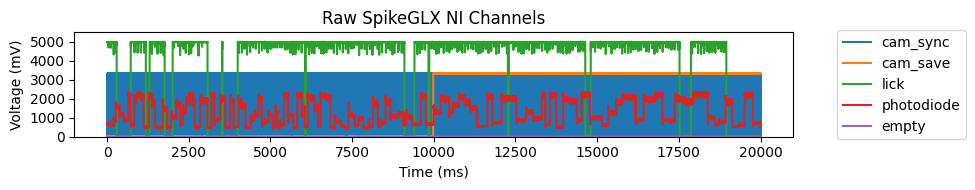

In [13]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=20)

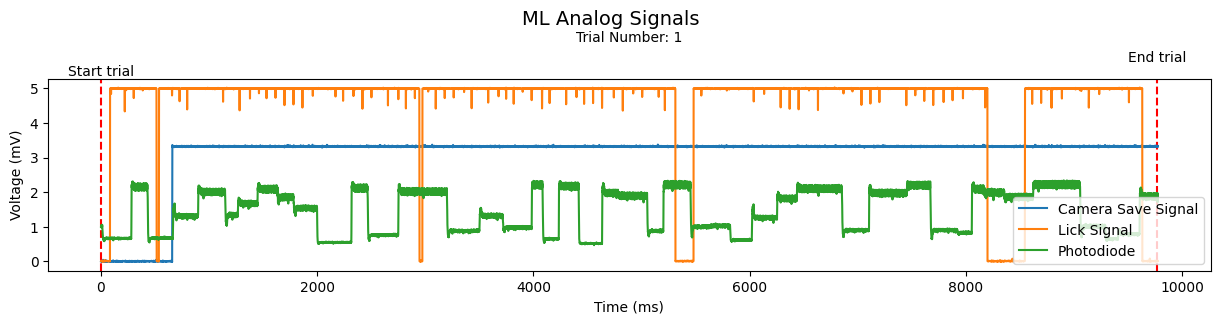

In [6]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

In [7]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

Found pickled spikeglx_obj: /Users/rahimhashim/Desktop/Monkey-Emotions/_data/gandalf_231023/spikeglx_obj_gandalf_231023.pkl
Updating spikeglx_obj paths...
  Updated sglx_dir_path to: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff/231023
  Deleted old video_file_paths
  Deleted old video_info
  Updating video_file_paths and video_info...
Video Folders:
['231023_Gandalf_105339', '231023_Gandalf_105556', '231023_Gandalf_112003']
Number of cameras: 4
  Camera: e3v831b | Number of videos: 5
  Camera: e3v8360 | Number of videos: 5
  Camera: e3v83ad | Number of videos: 5
  Camera: e3v83d6 | Number of videos: 5
Camera: e3v831b
  Video: e3v831b-20231023T105338-111339.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231023T111339-113340.avi | Frames: 144124 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231023T113340-115340.avi | Frames: 144004 | FPS: 120.0 | 

### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

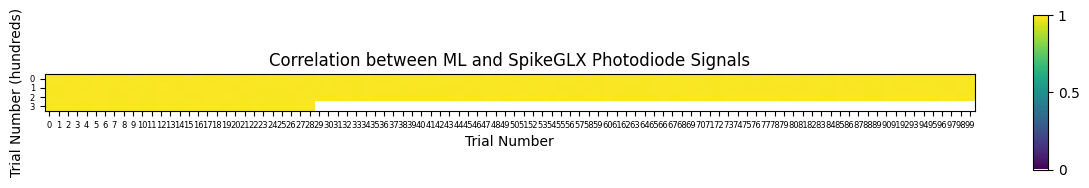

In [8]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [ ]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 0,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False}               # 'thread_flag': False

parse_wm_videos(**kwargs)

***
## DeepLabCut

In [9]:
import deeplabcut

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

Loading DLC 2.3.5...


In [10]:
from dlc_primate.dlc_utils import dlc_config, dlc_downsample
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231023


  0%|          | 0/1310 [00:00<?, ?it/s]

  Camera: e3v83d6 | Number of videos: 325
  Camera: e3v8360 | Number of videos: 335
  Camera: e3v831b | Number of videos: 325
  Camera: e3v83ad | Number of videos: 325


In [ ]:
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

# Initialize Project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)

In [ ]:
# Run DLC
dlc_config.dlc_run(config_path_dict, dlc_video_path_dict, 
                   start_video=0, end_video=None, videotype='mp4')

***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, session_obj, trial_num_selected, epoch_start, epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()